# A/B Test Analysis with spark-bestfit

This notebook demonstrates how to analyze **A/B test results** using statistical
distribution fitting with proper uncertainty quantification.

## What You'll Learn

1. **Model conversion rates** with bounded Beta distributions
2. **Quantify uncertainty** using bootstrap confidence intervals
3. **Analyze revenue per user** with mixed discrete-continuous data
4. **Calculate statistical significance** and practical effect sizes

## Business Context

A/B testing is fundamental to data-driven product development:

- **Feature launches**: Does the new checkout flow improve conversion?
- **Pricing experiments**: How does a 10% price change affect revenue?
- **UX optimization**: Which button color drives more clicks?

Beyond simple proportion tests, distribution fitting provides:

- **Full uncertainty quantification** via bootstrap intervals
- **Rich modeling** for non-normal metrics (revenue, time-on-site)
- **Scenario simulation** for business impact projections

## Prerequisites

```bash
pip install spark-bestfit pandas numpy matplotlib scipy
```

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from spark_bestfit import DistributionFitter

# Create Spark session
spark = SparkSession.builder \
    .appName("ABTest-Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/02 23:36:29 WARN Utils: Your hostname, 2025m5.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.201 instead (on interface en0)
26/01/02 23:36:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/02 23:36:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.0


## Part 1: Simulate A/B Test Data

We'll simulate a website conversion experiment:

- **Control (A)**: Current checkout page - 8% conversion rate
- **Treatment (B)**: New checkout design - 9.5% conversion rate (true lift)
- **Metric**: Revenue per visitor (converted users generate revenue)

In [2]:
np.random.seed(42)

# Experiment parameters
n_control = 5000       # Visitors in control
n_treatment = 5000     # Visitors in treatment
conv_rate_control = 0.08      # True conversion rate: 8%
conv_rate_treatment = 0.095   # True conversion rate: 9.5% (18.75% lift)

# Generate conversion events (0/1)
control_conversions = np.random.binomial(1, conv_rate_control, n_control)
treatment_conversions = np.random.binomial(1, conv_rate_treatment, n_treatment)

# Generate revenue for converted users (log-normal distribution)
# Average order value ~$75, skewed with some large orders
def generate_revenue(conversions, mean_aov=75, sigma=0.6):
    revenue = np.zeros(len(conversions))
    converted_mask = conversions == 1
    n_converted = converted_mask.sum()
    # Log-normal with mean ~$75
    mu = np.log(mean_aov) - (sigma**2 / 2)
    revenue[converted_mask] = np.random.lognormal(mu, sigma, n_converted)
    return revenue

control_revenue = generate_revenue(control_conversions)
treatment_revenue = generate_revenue(treatment_conversions, mean_aov=78)  # Slight AOV lift too

# Create DataFrames
control_df = pd.DataFrame({
    'group': 'control',
    'converted': control_conversions,
    'revenue': control_revenue
})

treatment_df = pd.DataFrame({
    'group': 'treatment',
    'converted': treatment_conversions,
    'revenue': treatment_revenue
})

experiment_df = pd.concat([control_df, treatment_df], ignore_index=True)

print("Experiment Summary:")
print(f"  Control: {n_control} visitors, {control_conversions.sum()} conversions ({control_conversions.mean():.2%})")
print(f"  Treatment: {n_treatment} visitors, {treatment_conversions.sum()} conversions ({treatment_conversions.mean():.2%})")
print(f"  Observed lift: {(treatment_conversions.mean() / control_conversions.mean() - 1):.1%}")

Experiment Summary:
  Control: 5000 visitors, 393 conversions (7.86%)
  Treatment: 5000 visitors, 466 conversions (9.32%)
  Observed lift: 18.6%


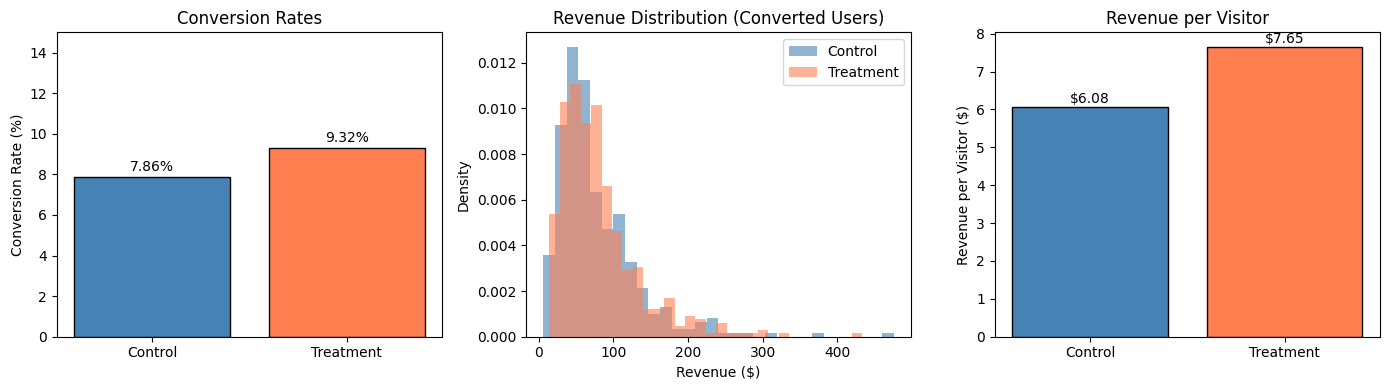

In [3]:
# Visualize the experiment data
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Conversion rates
rates = [control_conversions.mean() * 100, treatment_conversions.mean() * 100]
bars = axes[0].bar(['Control', 'Treatment'], rates, color=['steelblue', 'coral'], edgecolor='black')
axes[0].set_ylabel('Conversion Rate (%)')
axes[0].set_title('Conversion Rates')
axes[0].set_ylim(0, 15)
for bar, rate in zip(bars, rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{rate:.2f}%', ha='center')

# Revenue distribution (converted users only)
control_rev_converted = control_revenue[control_revenue > 0]
treatment_rev_converted = treatment_revenue[treatment_revenue > 0]
axes[1].hist(control_rev_converted, bins=30, alpha=0.6, label='Control', color='steelblue', density=True)
axes[1].hist(treatment_rev_converted, bins=30, alpha=0.6, label='Treatment', color='coral', density=True)
axes[1].set_xlabel('Revenue ($)')
axes[1].set_ylabel('Density')
axes[1].set_title('Revenue Distribution (Converted Users)')
axes[1].legend()

# Revenue per visitor (including zeros)
rpv_control = control_revenue.mean()
rpv_treatment = treatment_revenue.mean()
bars = axes[2].bar(['Control', 'Treatment'], [rpv_control, rpv_treatment], color=['steelblue', 'coral'], edgecolor='black')
axes[2].set_ylabel('Revenue per Visitor ($)')
axes[2].set_title('Revenue per Visitor')
for bar, rpv in zip(bars, [rpv_control, rpv_treatment]):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'${rpv:.2f}', ha='center')

plt.tight_layout()
plt.show()

## Part 2: Model Conversion Rates with Beta Distribution

For conversion rates (proportions between 0 and 1), the **Beta distribution** is ideal:

- Bounded on [0, 1] - natural for probabilities
- Conjugate prior for Bernoulli/Binomial - Bayesian interpretation
- Flexible shape - can model different conversion patterns

We'll use spark-bestfit's **bounded fitting** to find optimal parameters.

In [4]:
# For Beta fitting, we need individual conversion probabilities
# We'll use a bootstrap approach: resample visitors and compute conversion rates

def bootstrap_conversion_rates(conversions, n_bootstrap=1000, sample_size=500, seed=42):
    """Generate bootstrap samples of conversion rates."""
    np.random.seed(seed)
    rates = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(conversions, size=sample_size, replace=True)
        rates.append(sample.mean())
    return np.array(rates)

# Generate bootstrap conversion rate samples
control_rates = bootstrap_conversion_rates(control_conversions)
treatment_rates = bootstrap_conversion_rates(treatment_conversions)

# Create Spark DataFrames for fitting
control_spark = spark.createDataFrame(
    pd.DataFrame({'conversion_rate': control_rates})
)
treatment_spark = spark.createDataFrame(
    pd.DataFrame({'conversion_rate': treatment_rates})
)

print(f"Bootstrap samples: {len(control_rates)} rates per group")
print(f"Control rates: mean={control_rates.mean():.4f}, std={control_rates.std():.4f}")
print(f"Treatment rates: mean={treatment_rates.mean():.4f}, std={treatment_rates.std():.4f}")

Bootstrap samples: 1000 rates per group
Control rates: mean=0.0791, std=0.0120
Treatment rates: mean=0.0929, std=0.0129


In [5]:
# Fit bounded distributions to conversion rates
# Bounded fitting on [0, 1] naturally selects Beta distribution
fitter = DistributionFitter(spark)

# Fit control group - use bounded fitting for [0, 1] range
control_results = fitter.fit(
    control_spark,
    column='conversion_rate',
    bounded=True,
    lower_bound=0.0,
    upper_bound=1.0,
    max_distributions=10,  # Limit for speed
    lazy_metrics=True
)

# Fit treatment group
treatment_results = fitter.fit(
    treatment_spark,
    column='conversion_rate',
    bounded=True,
    lower_bound=0.0,
    upper_bound=1.0,
    max_distributions=10,
    lazy_metrics=True
)

# Get best fits (explicitly use AIC metric)
# Beta typically wins for [0,1] bounded data
control_fit = control_results.best(n=1, metric='aic')[0]
treatment_fit = treatment_results.best(n=1, metric='aic')[0]

print("Distribution Fits (bounded [0, 1]):")
print(f"\nControl: {control_fit.distribution}")
print(f"  Parameters: {control_fit.parameters}")
print(f"  AIC: {control_fit.aic:.2f}")

print(f"\nTreatment: {treatment_fit.distribution}")
print(f"  Parameters: {treatment_fit.parameters}")
print(f"  AIC: {treatment_fit.aic:.2f}")

Distribution Fits (bounded [0, 1]):

Control: alpha
  Parameters: [24.23857307434082, -0.21055598556995392, 7.009453296661377]
  AIC: -6007.74

Treatment: beta
  Parameters: [10.255008697509766, 22.879335403442383, 0.04246443137526512, 0.16287091374397278]
  AIC: -5872.90


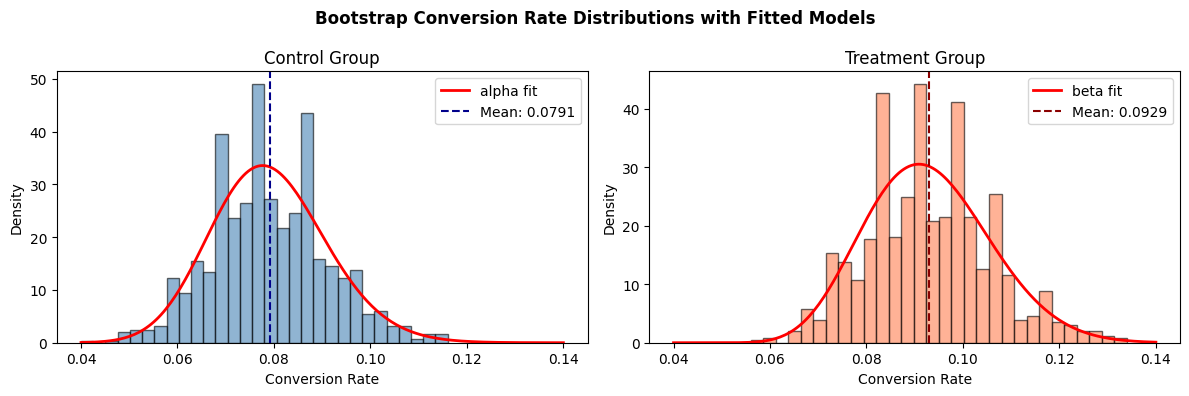

In [6]:
# Visualize fitted distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x = np.linspace(0.04, 0.14, 200)

# Control - use get_scipy_dist() for frozen distribution
control_dist = control_fit.get_scipy_dist()
control_pdf = control_dist.pdf(x)
axes[0].hist(control_rates, bins=30, density=True, alpha=0.6, color='steelblue', edgecolor='black')
axes[0].plot(x, control_pdf, 'r-', lw=2, label=f'{control_fit.distribution} fit')
axes[0].axvline(control_rates.mean(), color='darkblue', linestyle='--', label=f'Mean: {control_rates.mean():.4f}')
axes[0].set_xlabel('Conversion Rate')
axes[0].set_ylabel('Density')
axes[0].set_title('Control Group')
axes[0].legend()

# Treatment
treatment_dist = treatment_fit.get_scipy_dist()
treatment_pdf = treatment_dist.pdf(x)
axes[1].hist(treatment_rates, bins=30, density=True, alpha=0.6, color='coral', edgecolor='black')
axes[1].plot(x, treatment_pdf, 'r-', lw=2, label=f'{treatment_fit.distribution} fit')
axes[1].axvline(treatment_rates.mean(), color='darkred', linestyle='--', label=f'Mean: {treatment_rates.mean():.4f}')
axes[1].set_xlabel('Conversion Rate')
axes[1].set_ylabel('Density')
axes[1].set_title('Treatment Group')
axes[1].legend()

plt.suptitle('Bootstrap Conversion Rate Distributions with Fitted Models', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 3: Bootstrap Confidence Intervals

Using the fitted distributions, we can compute confidence intervals for:

1. Individual group conversion rates
2. The **lift** (relative improvement)
3. The **absolute difference**

In [7]:
# Calculate confidence intervals from bootstrap samples
def confidence_interval(data, confidence=0.95):
    """Calculate percentile confidence interval."""
    alpha = 1 - confidence
    lower = np.percentile(data, alpha/2 * 100)
    upper = np.percentile(data, (1 - alpha/2) * 100)
    return lower, upper

# Individual CIs
control_ci = confidence_interval(control_rates)
treatment_ci = confidence_interval(treatment_rates)

# Lift distribution (pairwise comparison of bootstrap samples)
lift_samples = (treatment_rates - control_rates) / control_rates
lift_ci = confidence_interval(lift_samples)

# Absolute difference
diff_samples = treatment_rates - control_rates
diff_ci = confidence_interval(diff_samples)

print("95% Confidence Intervals:")
print(f"\nControl Conversion Rate:")
print(f"  Point estimate: {control_rates.mean():.4f} ({control_rates.mean()*100:.2f}%)")
print(f"  95% CI: [{control_ci[0]:.4f}, {control_ci[1]:.4f}]")

print(f"\nTreatment Conversion Rate:")
print(f"  Point estimate: {treatment_rates.mean():.4f} ({treatment_rates.mean()*100:.2f}%)")
print(f"  95% CI: [{treatment_ci[0]:.4f}, {treatment_ci[1]:.4f}]")

print(f"\nRelative Lift:")
print(f"  Point estimate: {lift_samples.mean()*100:.1f}%")
print(f"  95% CI: [{lift_ci[0]*100:.1f}%, {lift_ci[1]*100:.1f}%]")

print(f"\nAbsolute Difference:")
print(f"  Point estimate: {diff_samples.mean()*100:.2f} percentage points")
print(f"  95% CI: [{diff_ci[0]*100:.2f}, {diff_ci[1]*100:.2f}] pp")

# Statistical significance
prob_treatment_better = (diff_samples > 0).mean()
print(f"\nP(Treatment > Control): {prob_treatment_better:.1%}")

95% Confidence Intervals:

Control Conversion Rate:
  Point estimate: 0.0791 (7.91%)
  95% CI: [0.0560, 0.1040]

Treatment Conversion Rate:
  Point estimate: 0.0929 (9.29%)
  95% CI: [0.0700, 0.1200]

Relative Lift:
  Point estimate: 20.2%
  95% CI: [-20.0%, 79.4%]

Absolute Difference:
  Point estimate: 1.38 percentage points
  95% CI: [-1.80, 4.80] pp

P(Treatment > Control): 76.4%


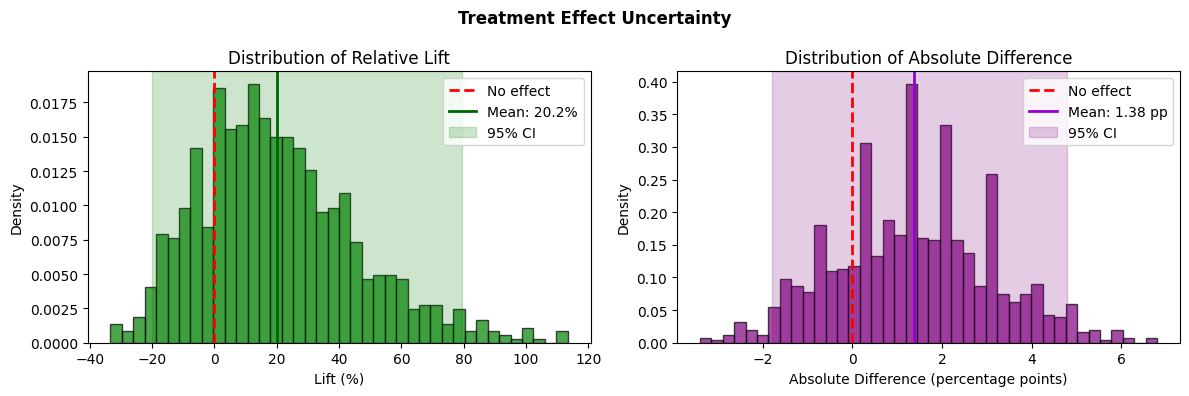

In [8]:
# Visualize lift distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Lift distribution
axes[0].hist(lift_samples * 100, bins=40, density=True, alpha=0.7, color='green', edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', lw=2, label='No effect')
axes[0].axvline(lift_samples.mean() * 100, color='darkgreen', linestyle='-', lw=2, label=f'Mean: {lift_samples.mean()*100:.1f}%')
axes[0].axvspan(lift_ci[0]*100, lift_ci[1]*100, alpha=0.2, color='green', label='95% CI')
axes[0].set_xlabel('Lift (%)')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Relative Lift')
axes[0].legend()

# Absolute difference distribution
axes[1].hist(diff_samples * 100, bins=40, density=True, alpha=0.7, color='purple', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', lw=2, label='No effect')
axes[1].axvline(diff_samples.mean() * 100, color='darkviolet', linestyle='-', lw=2, label=f'Mean: {diff_samples.mean()*100:.2f} pp')
axes[1].axvspan(diff_ci[0]*100, diff_ci[1]*100, alpha=0.2, color='purple', label='95% CI')
axes[1].set_xlabel('Absolute Difference (percentage points)')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Absolute Difference')
axes[1].legend()

plt.suptitle('Treatment Effect Uncertainty', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 4: Revenue per Visitor Analysis

Revenue per visitor is a more complex metric:

- **Zero-inflated**: Most visitors don't convert (revenue = $0)
- **Heavy-tailed**: Converted users show skewed revenue (some large orders)

We'll fit distributions to **converted users only**, then combine with conversion rates.

In [9]:
# Fit revenue distribution for converted users
control_rev = control_revenue[control_revenue > 0]
treatment_rev = treatment_revenue[treatment_revenue > 0]

# Create Spark DataFrames
control_rev_spark = spark.createDataFrame(pd.DataFrame({'revenue': control_rev}))
treatment_rev_spark = spark.createDataFrame(pd.DataFrame({'revenue': treatment_rev}))

# Fit distributions (limited set for speed, includes heavy-tailed options)
control_rev_results = fitter.fit(
    control_rev_spark,
    column='revenue',
    max_distributions=15,  # Includes lognorm, gamma, weibull, pareto, etc.
    lazy_metrics=True
)

treatment_rev_results = fitter.fit(
    treatment_rev_spark,
    column='revenue',
    max_distributions=15,
    lazy_metrics=True
)

print("Revenue Distribution Fits (Converted Users):")
print(f"\nControl - Best fits by AIC:")
for fit in control_rev_results.best(n=3, metric='aic'):
    print(f"  {fit.distribution}: AIC={fit.aic:.1f}")

print(f"\nTreatment - Best fits by AIC:")
for fit in treatment_rev_results.best(n=3, metric='aic'):
    print(f"  {fit.distribution}: AIC={fit.aic:.1f}")

Revenue Distribution Fits (Converted Users):

Control - Best fits by AIC:
  betaprime: AIC=4032.3
  burr12: AIC=4035.6
  burr: AIC=4035.9

Treatment - Best fits by AIC:
  betaprime: AIC=4798.0
  chi2: AIC=4800.5
  beta: AIC=4802.5


In [10]:
# Get best revenue fits (explicitly use AIC metric)
control_rev_fit = control_rev_results.best(n=1, metric='aic')[0]
treatment_rev_fit = treatment_rev_results.best(n=1, metric='aic')[0]

print(f"Best Control Revenue Fit: {control_rev_fit.distribution}")
print(f"  Parameters: {control_rev_fit.parameters}")
print(f"  Mean: ${control_rev.mean():.2f}")

print(f"\nBest Treatment Revenue Fit: {treatment_rev_fit.distribution}")
print(f"  Parameters: {treatment_rev_fit.parameters}")
print(f"  Mean: ${treatment_rev.mean():.2f}")

Best Control Revenue Fit: betaprime
  Parameters: [7.510149002075195, 5.40263032913208, -4.992238521575928, 48.278343200683594]
  Mean: $77.29

Best Treatment Revenue Fit: betaprime
  Parameters: [3.4718339443206787, 6.641073226928711, 7.961455345153809, 119.25703430175781]
  Mean: $82.12


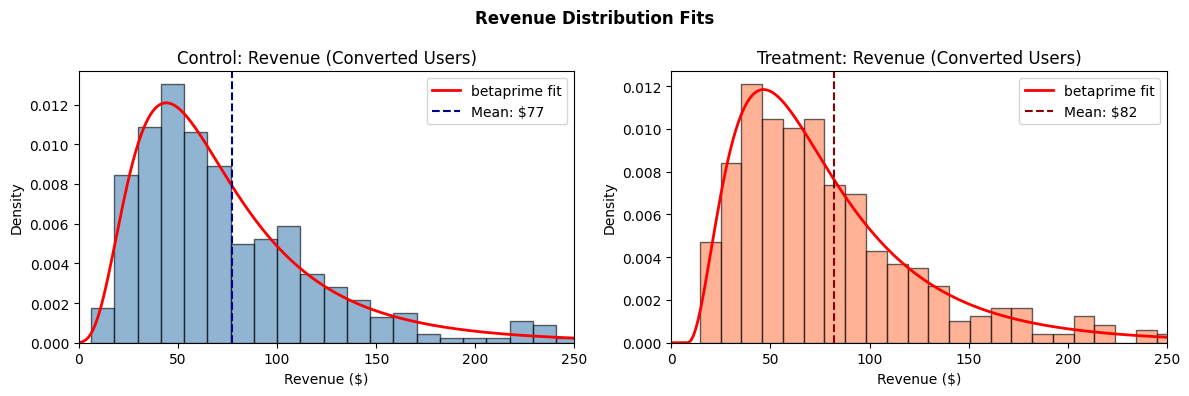

In [11]:
# Visualize revenue fits
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x = np.linspace(1, 250, 200)

# Control revenue - use get_scipy_dist() for frozen distribution
control_rev_dist = control_rev_fit.get_scipy_dist()
control_pdf = control_rev_dist.pdf(x)

axes[0].hist(control_rev, bins=40, density=True, alpha=0.6, color='steelblue', edgecolor='black')
axes[0].plot(x, control_pdf, 'r-', lw=2, label=f'{control_rev_fit.distribution} fit')
axes[0].axvline(control_rev.mean(), color='darkblue', linestyle='--', label=f'Mean: ${control_rev.mean():.0f}')
axes[0].set_xlabel('Revenue ($)')
axes[0].set_ylabel('Density')
axes[0].set_title('Control: Revenue (Converted Users)')
axes[0].legend()
axes[0].set_xlim(0, 250)

# Treatment revenue
treatment_rev_dist = treatment_rev_fit.get_scipy_dist()
treatment_pdf = treatment_rev_dist.pdf(x)

axes[1].hist(treatment_rev, bins=40, density=True, alpha=0.6, color='coral', edgecolor='black')
axes[1].plot(x, treatment_pdf, 'r-', lw=2, label=f'{treatment_rev_fit.distribution} fit')
axes[1].axvline(treatment_rev.mean(), color='darkred', linestyle='--', label=f'Mean: ${treatment_rev.mean():.0f}')
axes[1].set_xlabel('Revenue ($)')
axes[1].set_ylabel('Density')
axes[1].set_title('Treatment: Revenue (Converted Users)')
axes[1].legend()
axes[1].set_xlim(0, 250)

plt.suptitle('Revenue Distribution Fits', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 5: Combined Business Impact

Now we combine conversion rate and revenue models to estimate total business impact.

In [12]:
# Calculate Revenue per Visitor (RPV) confidence intervals
# RPV = Conversion Rate × Average Order Value

# Bootstrap RPV
def bootstrap_rpv(conversions, revenue, n_bootstrap=1000, seed=42):
    """Bootstrap revenue per visitor."""
    np.random.seed(seed)
    rpvs = []
    n = len(conversions)
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, size=n, replace=True)
        rpvs.append(revenue[idx].mean())
    return np.array(rpvs)

control_rpv = bootstrap_rpv(control_conversions, control_revenue)
treatment_rpv = bootstrap_rpv(treatment_conversions, treatment_revenue)

# RPV lift
rpv_lift = (treatment_rpv - control_rpv) / control_rpv
rpv_diff = treatment_rpv - control_rpv

control_rpv_ci = confidence_interval(control_rpv)
treatment_rpv_ci = confidence_interval(treatment_rpv)
rpv_lift_ci = confidence_interval(rpv_lift)
rpv_diff_ci = confidence_interval(rpv_diff)

print("Revenue per Visitor Analysis:")
print(f"\nControl RPV:")
print(f"  Point estimate: ${control_rpv.mean():.2f}")
print(f"  95% CI: [${control_rpv_ci[0]:.2f}, ${control_rpv_ci[1]:.2f}]")

print(f"\nTreatment RPV:")
print(f"  Point estimate: ${treatment_rpv.mean():.2f}")
print(f"  95% CI: [${treatment_rpv_ci[0]:.2f}, ${treatment_rpv_ci[1]:.2f}]")

print(f"\nRPV Lift:")
print(f"  Point estimate: {rpv_lift.mean()*100:.1f}%")
print(f"  95% CI: [{rpv_lift_ci[0]*100:.1f}%, {rpv_lift_ci[1]*100:.1f}%]")

print(f"\nRPV Difference:")
print(f"  Point estimate: ${rpv_diff.mean():.2f} per visitor")
print(f"  95% CI: [${rpv_diff_ci[0]:.2f}, ${rpv_diff_ci[1]:.2f}]")

Revenue per Visitor Analysis:

Control RPV:
  Point estimate: $6.10
  95% CI: [$5.37, $6.82]

Treatment RPV:
  Point estimate: $7.67
  95% CI: [$6.89, $8.50]

RPV Lift:
  Point estimate: 26.3%
  95% CI: [7.4%, 47.6%]

RPV Difference:
  Point estimate: $1.57 per visitor
  95% CI: [$0.50, $2.68]


In [13]:
# Project annual impact
annual_visitors = 1_000_000  # 1M visitors per year

annual_impact = rpv_diff * annual_visitors
annual_impact_ci = confidence_interval(annual_impact)

print(f"Projected Annual Revenue Impact:")
print(f"  Assuming {annual_visitors:,} annual visitors")
print(f"\n  Point estimate: ${annual_impact.mean():,.0f}")
print(f"  95% CI: [${annual_impact_ci[0]:,.0f}, ${annual_impact_ci[1]:,.0f}]")
print(f"\n  P(Positive Impact): {(annual_impact > 0).mean():.1%}")

Projected Annual Revenue Impact:
  Assuming 1,000,000 annual visitors

  Point estimate: $1,572,308
  95% CI: [$501,206, $2,679,560]

  P(Positive Impact): 99.8%


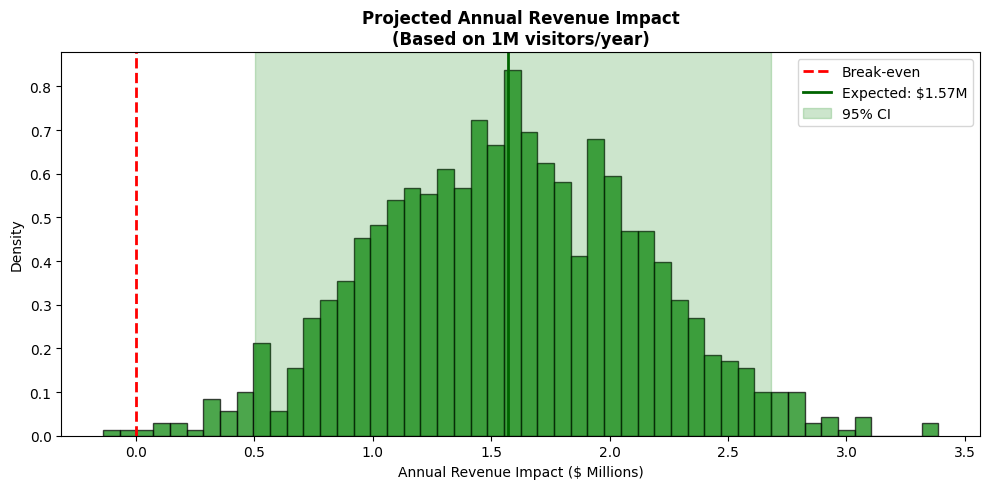

In [14]:
# Visualize annual impact distribution
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(annual_impact / 1e6, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', lw=2, label='Break-even')
ax.axvline(annual_impact.mean() / 1e6, color='darkgreen', linestyle='-', lw=2, 
           label=f'Expected: ${annual_impact.mean()/1e6:.2f}M')
ax.axvspan(annual_impact_ci[0]/1e6, annual_impact_ci[1]/1e6, alpha=0.2, color='green', label='95% CI')

ax.set_xlabel('Annual Revenue Impact ($ Millions)')
ax.set_ylabel('Density')
ax.set_title(f'Projected Annual Revenue Impact\n(Based on {annual_visitors/1e6:.0f}M visitors/year)', 
             fontsize=12, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

## Part 6: Decision Framework

Use the distribution fits to make data-driven launch decisions.

In [15]:
# Decision metrics
min_acceptable_lift = 0.05  # 5% minimum lift to launch
implementation_cost = 50_000  # One-time cost to implement

# Probability of meeting minimum lift
prob_min_lift = (rpv_lift >= min_acceptable_lift).mean()

# Expected ROI
expected_annual_gain = annual_impact.mean()
expected_roi = (expected_annual_gain - implementation_cost) / implementation_cost

# Risk metrics
prob_negative = (annual_impact < 0).mean()
worst_case = np.percentile(annual_impact, 5)  # 5th percentile
best_case = np.percentile(annual_impact, 95)  # 95th percentile

print("="*60)
print("A/B TEST DECISION REPORT")
print("="*60)

print(f"\n KEY METRICS:")
print(f"   Conversion Rate Lift: {lift_samples.mean()*100:.1f}% (95% CI: [{lift_ci[0]*100:.1f}%, {lift_ci[1]*100:.1f}%])")
print(f"   RPV Lift: {rpv_lift.mean()*100:.1f}% (95% CI: [{rpv_lift_ci[0]*100:.1f}%, {rpv_lift_ci[1]*100:.1f}%])")

print(f"\n BUSINESS IMPACT (Annual):")
print(f"   Expected Revenue: ${expected_annual_gain:,.0f}")
print(f"   Implementation Cost: ${implementation_cost:,}")
print(f"   Expected 1-Year ROI: {expected_roi:.0%}")

print(f"\n  RISK ASSESSMENT:")
print(f"   P(Negative Impact): {prob_negative:.1%}")
print(f"   P(Lift ≥ {min_acceptable_lift:.0%}): {prob_min_lift:.1%}")
print(f"   Worst Case (5%): ${worst_case:,.0f}")
print(f"   Best Case (95%): ${best_case:,.0f}")

print(f"\n RECOMMENDATION:")
if prob_negative < 0.05 and prob_min_lift > 0.80:
    print("   LAUNCH - Strong evidence of positive impact")
elif prob_negative < 0.10 and prob_min_lift > 0.50:
    print("   CONSIDER LAUNCHING - Moderate evidence, acceptable risk")
else:
    print("   CONTINUE TESTING - Insufficient evidence or high risk")

print("\n" + "="*60)

A/B TEST DECISION REPORT

 KEY METRICS:
   Conversion Rate Lift: 20.2% (95% CI: [-20.0%, 79.4%])
   RPV Lift: 26.3% (95% CI: [7.4%, 47.6%])

 BUSINESS IMPACT (Annual):
   Expected Revenue: $1,572,308
   Implementation Cost: $50,000
   Expected 1-Year ROI: 3045%

  RISK ASSESSMENT:
   P(Negative Impact): 0.2%
   P(Lift ≥ 5%): 98.7%
   Worst Case (5%): $673,283
   Best Case (95%): $2,495,821

 RECOMMENDATION:
   LAUNCH - Strong evidence of positive impact



## Summary

This notebook demonstrated A/B test analysis with spark-bestfit:

1. **Beta distribution fitting** for conversion rates with bounded support
2. **Bootstrap confidence intervals** for uncertainty quantification
3. **Revenue modeling** with heavy-tailed distributions
4. **Business impact projection** combining conversion and revenue models
5. **Decision framework** with ROI and risk metrics

### Key spark-bestfit Features Used

| Feature | Purpose |
|---------|----------|
| `bounded=True` | Fit Beta to [0, 1] proportions |
| `lazy_metrics=True` | Fast model selection |
| Custom distributions | Target heavy-tailed revenue |
| `results.best(n=3)` | Compare top candidates |

### Extensions

- **Bayesian approach**: Use Beta as prior, update with data
- **Sequential testing**: Early stopping with alpha spending
- **Segment analysis**: Fit separate models per user segment
- **Multi-arm bandits**: Adaptive allocation based on fitted posteriors

In [16]:
# Cleanup
spark.stop()